---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [10]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys

sys.path.append("../scripts")
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv

load_dotenv()

pd.set_option("display.max_colwidth", 80)
print("All imports successful!")

All imports successful!


In [11]:
# Load the WANDS dataset
products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [12]:
# Copy your BM25 functions from Homework 3

# Import additional dependencies for BM25
import Stemmer
import string
from collections import Counter

# Setup tokenizer
stemmer = Stemmer.Stemmer("english")
punct_trans = str.maketrans({key: " " for key in string.punctuation})


def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.

    Args:
        text: The text to tokenize

    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]


def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.

    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens

    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []

    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)

        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count

    return index, doc_lengths


def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.

    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index

    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0


def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.

    Args:
        term: The term to look up
        index: The inverted index

    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0


def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.

    Args:
        df: Document frequency
        num_docs: Total number of documents

    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)


def bm25_tf(
    tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75
) -> float:
    """
    BM25 TF normalization.

    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)

    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))


def score_bm25(
    query: str,
    index: dict,
    num_docs: int,
    doc_lengths: list[int],
    tokenizer,
    k1: float = 1.2,
    b: float = 0.75,
) -> np.ndarray:
    """
    Score all documents using BM25.

    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function

    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0

    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue

        idf = bm25_idf(df, num_docs)

        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm

    return scores


def search_products(
    query: str,
    products_df: pd.DataFrame,
    index: dict,
    doc_lengths: list[int],
    tokenizer,
    k: int = 10,
) -> pd.DataFrame:
    """
    Search products and return top-k results.

    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return

    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]

    results = products_df.iloc[top_k_idx].copy()
    results["score"] = scores[top_k_idx]
    results["rank"] = range(1, k + 1)
    return results


print("BM25 functions loaded successfully!")


BM25 functions loaded successfully!


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [13]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
# Then generate embeddings for each word in the list
words = [
    "wooden coffee table",
    "oak dining table",
    "red leather sofa",
    "blue area rug",
    "kitchen sink",
]

# Load the model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for all words
embeddings = model.encode(words)

# Print the number of embeddings you generated and the dimension of the embeddings
print(f"Number of embeddings: {len(embeddings)}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"\nFirst embedding (truncated): {embeddings[0][:10]}...")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1681.21it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of embeddings: 5
Embedding dimension: 384

Embeddings shape: (5, 384)

First embedding (truncated): [ 0.01236607  0.02324472 -0.02702161  0.02981181 -0.02943876  0.00525406
  0.0480969  -0.01932196  0.04702966  0.03441385]...


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [14]:
# Implement cosine similarity from scratch
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Calculate cosine similarity between two vectors.
    
    Formula: cos(a, b) = (a · b) / (||a|| × ||b||)
    
    Args:
        a: First embedding vector
        b: Second embedding vector
    
    Returns:
        Cosine similarity score between -1 and 1
    """
    # Dot product of the two vectors
    dot_product = np.dot(a, b)
    
    # L2 norms (magnitudes) of each vector
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    # Cosine similarity
    return dot_product / (norm_a * norm_b)


# Create similarity matrix
n = len(embeddings)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

# Display as DataFrame
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=words,
    columns=words
)

print("Cosine Similarity Matrix:")
print(similarity_df.round(3))

Cosine Similarity Matrix:
                     wooden coffee table  oak dining table  red leather sofa  \
wooden coffee table                1.000             0.589             0.371   
oak dining table                   0.589             1.000             0.338   
red leather sofa                   0.371             0.338             1.000   
blue area rug                      0.189             0.250             0.380   
kitchen sink                       0.296             0.341             0.058   

                     blue area rug  kitchen sink  
wooden coffee table          0.189         0.296  
oak dining table             0.250         0.341  
red leather sofa             0.380         0.058  
blue area rug                1.000         0.126  
kitchen sink                 0.126         1.000  


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [15]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
# Compare the dimension with the local model

# Get embedding for a sample text
sample_text = "wooden coffee table"

# Use litellm to get embedding from OpenAI
response = litellm.embedding(
    model="text-embedding-3-small",
    input=[sample_text]
)

# Extract the embedding
openai_embedding = response.data[0]["embedding"]

# Print comparison
print(f"Sample text: '{sample_text}'")
print(f"\nLocal model (all-MiniLM-L6-v2):")
print(f"  Dimension: {embeddings.shape[1]}")
print(f"\nOpenAI API (text-embedding-3-small):")
print(f"  Dimension: {len(openai_embedding)}")
print(f"\nDimension difference: {len(openai_embedding) - embeddings.shape[1]}")
print(f"\nOpenAI embedding (first 10 values): {openai_embedding[:10]}")

Sample text: 'wooden coffee table'

Local model (all-MiniLM-L6-v2):
  Dimension: 384

OpenAI API (text-embedding-3-small):
  Dimension: 1536

Dimension difference: 1152

OpenAI embedding (first 10 values): [-0.025003126, -0.010913782, 0.027789121, -0.049911812, 0.01913601, -0.050384015, 0.015134092, 0.0342583, 0.0047899047, -0.033833314]


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [16]:
# Get a consistent sample
np.random.seed(42)
products_sample = products.sample(n=5000, random_state=42).reset_index(drop=True)

print(f"Sampled {len(products_sample):,} products")
print(f"\nFirst few products:")
products_sample.head()


Sampled 5,000 products

First few products:


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,32193,woven wire basket,"Boxes, Bins, Baskets, & Buckets",Storage & Organization / Storage Containers & Drawers / All Storage Containers,NaN,overalldepth-fronttoback:18|producttype : basket|features : stackable|overal...,21.0,5.0,19.0
1,21379,scallop nightstand,Kids Nightstands,Baby & Kids / Toddler & Kids Bedroom Furniture / Kids Nightstands / Green Ki...,the scallop collection shows off its charming and lovely design with the sca...,framematerialdetails : mdf and plywood|theme : neutral|framematerial : manuf...,2.0,5.0,2.0
2,42275,ybm home stainless steel colander,"Strainers, Colanders, & Salad Spinners","Kitchen & Tabletop / Kitchen Utensils & Tools / Colanders, Strainers, & Sala...",this stainless steel colander with side handles will come in handy in your b...,overalldepth-fronttoback:11|overallproductweight:0.68|producttype : colander...,26.0,4.5,15.0
3,29885,oneida 2 piece stainless steel strainer set,"Strainers, Colanders, & Salad Spinners","Kitchen & Tabletop / Kitchen Utensils & Tools / Colanders, Strainers, & Sala...",NaN,producttype : strainer set|materialfinish : stainless steel|warrantylength :...,1.0,5.0,1.0
4,8194,ryland platform bed frame,Bed Frames|Beds,NaN,update the look of your room by adding the upholstered platform bed frame . ...,color : black|overallwidth-sidetoside:60|overalllength-headtotoe:75|overallh...,2659.0,4.5,1676.0


In [17]:
# Create a combined text field (product_name + product_class)
# Then embed all products using model.encode()

# Create combined text field, handling missing values
products_sample["combined_text"] = (
    products_sample["product_name"].fillna("") + " " + 
    products_sample["product_class"].fillna("")
).str.strip()

# Check for any empty or invalid entries
print(f"Total products: {len(products_sample)}")
print(f"Empty combined_text entries: {(products_sample['combined_text'] == '').sum()}")

print("\nCombined text examples:")
print(products_sample[["product_name", "product_class", "combined_text"]].head(3))

# Embed all products using the local model
print(f"\nEmbedding {len(products_sample):,} products...")
start_time = time.time()

# Convert to list of strings, ensuring all are valid strings
texts_to_embed = [str(text) if text else "unknown product" for text in products_sample["combined_text"].tolist()]

product_embeddings = model.encode(
    texts_to_embed,
    show_progress_bar=True,
    batch_size=32
)

elapsed = time.time() - start_time

print(f"\nEmbedding complete!")
print(f"Time taken: {elapsed:.2f} seconds")
print(f"Products embedded: {len(product_embeddings):,}")
print(f"Embedding shape: {product_embeddings.shape}")
print(f"Dimension: {product_embeddings.shape[1]}")


Total products: 5000
Empty combined_text entries: 0

Combined text examples:
                        product_name                           product_class  \
0                  woven wire basket         Boxes, Bins, Baskets, & Buckets   
1                 scallop nightstand                        Kids Nightstands   
2  ybm home stainless steel colander  Strainers, Colanders, & Salad Spinners   

                                                              combined_text  
0                         woven wire basket Boxes, Bins, Baskets, & Buckets  
1                                       scallop nightstand Kids Nightstands  
2  ybm home stainless steel colander Strainers, Colanders, & Salad Spinners  

Embedding 5,000 products...


Batches: 100%|██████████| 157/157 [00:04<00:00, 38.73it/s]


Embedding complete!
Time taken: 4.07 seconds
Products embedded: 5,000
Embedding shape: (5000, 384)
Dimension: 384


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [18]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
# Then load them back and verify they match

from pathlib import Path

# Create temp directory if it doesn't exist
temp_dir = Path("../temp")
temp_dir.mkdir(exist_ok=True)

# Save embeddings as .npy file
embeddings_path = temp_dir / "hw4_embeddings.npy"
np.save(embeddings_path, product_embeddings)
print(f"Saved embeddings to: {embeddings_path}")
print(f"File size: {embeddings_path.stat().st_size / 1024 / 1024:.2f} MB")

# Save products sample as CSV
products_path = temp_dir / "hw4_products.csv"
products_sample.to_csv(products_path, index=False)
print(f"\nSaved products to: {products_path}")
print(f"File size: {products_path.stat().st_size / 1024 / 1024:.2f} MB")

# Load them back
print("\n" + "="*50)
print("Loading files back...")
print("="*50)

loaded_embeddings = np.load(embeddings_path)
loaded_products = pd.read_csv(products_path)

# Verify they match
print(f"\nOriginal embeddings shape: {product_embeddings.shape}")
print(f"Loaded embeddings shape: {loaded_embeddings.shape}")
print(f"Embeddings match: {np.allclose(product_embeddings, loaded_embeddings)}")

print(f"\nOriginal products count: {len(products_sample)}")
print(f"Loaded products count: {len(loaded_products)}")
print(f"Products match: {len(products_sample) == len(loaded_products)}")

print("\n✓ Save and load successful!")


Saved embeddings to: ../temp/hw4_embeddings.npy
File size: 7.32 MB

Saved products to: ../temp/hw4_products.csv
File size: 10.39 MB

Loading files back...

Original embeddings shape: (5000, 384)
Loaded embeddings shape: (5000, 384)
Embeddings match: True

Original products count: 5000
Loaded products count: 5000
Products match: True

✓ Save and load successful!


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [19]:
# Use tiktoken to count actual tokens in the sample
# Then extrapolate to estimate cost for the full dataset

import tiktoken

# Get the tokenizer for OpenAI's embedding model
encoding = tiktoken.get_encoding("cl100k_base")  # Used by text-embedding-3-small

# Count tokens for all products in the sample
total_tokens_sample = 0
for text in products_sample["combined_text"]:
    tokens = encoding.encode(str(text))
    total_tokens_sample += len(tokens)

# Calculate average tokens per product
avg_tokens_per_product = total_tokens_sample / len(products_sample)

print(f"Sample size: {len(products_sample):,} products")
print(f"Total tokens in sample: {total_tokens_sample:,}")
print(f"Average tokens per product: {avg_tokens_per_product:.2f}")

# Extrapolate to full dataset
total_products = len(products)
estimated_total_tokens = avg_tokens_per_product * total_products

print(f"\n{'='*50}")
print(f"Full dataset estimate:")
print(f"{'='*50}")
print(f"Total products: {total_products:,}")
print(f"Estimated total tokens: {estimated_total_tokens:,.0f}")

# Calculate cost
# Pricing: $0.02 per 1 million tokens
cost_per_million = 0.02
estimated_cost = (estimated_total_tokens / 1_000_000) * cost_per_million

print(f"\n💰 Estimated cost: ${estimated_cost:.4f}")
print(f"   (at ${cost_per_million} per 1M tokens)")

# Compare with local embedding (free!)
print(f"\n📊 Comparison:")
print(f"   OpenAI API: ${estimated_cost:.4f}")
print(f"   Local model: $0.00 (free!)")
print(f"   Savings: ${estimated_cost:.4f}")


Sample size: 5,000 products
Total tokens in sample: 64,753
Average tokens per product: 12.95

Full dataset estimate:
Total products: 42,994
Estimated total tokens: 556,798

💰 Estimated cost: $0.0111
   (at $0.02 per 1M tokens)

📊 Comparison:
   OpenAI API: $0.0111
   Local model: $0.00 (free!)
   Savings: $0.0111


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [20]:
# Implement batch cosine similarity for efficiency
def batch_cosine_similarity(query_embedding: np.ndarray, doc_embeddings: np.ndarray) -> np.ndarray:
    """
    Calculate cosine similarity between a query and multiple documents efficiently.
    
    Uses vectorized operations instead of loops for better performance.
    
    Args:
        query_embedding: Single embedding vector of shape (dim,)
        doc_embeddings: Multiple embedding vectors of shape (num_docs, dim)
    
    Returns:
        Array of similarity scores of shape (num_docs,)
    """
    # Normalize the query embedding (L2 norm)
    query_norm = query_embedding / np.linalg.norm(query_embedding)
    
    # Normalize all document embeddings (L2 norm)
    doc_norms = doc_embeddings / np.linalg.norm(doc_embeddings, axis=1, keepdims=True)
    
    # Compute dot product (which is cosine similarity for normalized vectors)
    similarities = np.dot(doc_norms, query_norm)
    
    return similarities

print("✓ Batch cosine similarity function implemented!")


✓ Batch cosine similarity function implemented!


In [21]:
# Implement semantic search
def semantic_search(
    query: str,
    model: SentenceTransformer,
    doc_embeddings: np.ndarray,
    products_df: pd.DataFrame,
    top_k: int = 10
) -> pd.DataFrame:
    """
    Search products using semantic similarity (embeddings).
    
    Args:
        query: Search query string
        model: SentenceTransformer model for embedding the query
        doc_embeddings: Pre-computed product embeddings
        products_df: DataFrame of products
        top_k: Number of results to return
    
    Returns:
        DataFrame with top-k products and similarity scores
    """
    # Embed the query
    query_embedding = model.encode(query)
    
    # Calculate similarity scores for all documents
    similarities = batch_cosine_similarity(query_embedding, doc_embeddings)
    
    # Get top-k indices (highest similarity scores)
    top_k_indices = np.argsort(-similarities)[:top_k]
    
    # Create results DataFrame
    results = products_df.iloc[top_k_indices].copy()
    results["score"] = similarities[top_k_indices]
    results["rank"] = range(1, top_k + 1)
    
    return results

print("✓ Semantic search function implemented!")


✓ Semantic search function implemented!


In [22]:
# Test semantic search
test_queries = [
    "comfortable couch",
    "wooden dining table",
    "modern office chair"
]

print("Testing Semantic Search")
print("=" * 80)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 80)
    
    results = semantic_search(
        query=query,
        model=model,
        doc_embeddings=product_embeddings,
        products_df=products_sample,
        top_k=5
    )
    
    # Display results
    for idx, row in results.iterrows():
        print(f"{row['rank']}. {row['product_name'][:60]:60} | Score: {row['score']:.4f}")
        print(f"   Class: {row['product_class']}")
    
print("\n" + "=" * 80)
print("✓ Semantic search is working!")

Testing Semantic Search

Query: 'comfortable couch'
--------------------------------------------------------------------------------
1. sofa bed with ottoman                                        | Score: 0.6673
   Class: nan
2. convertible sectional sofa couch , l-shaped couch with moder | Score: 0.6395
   Class: Sectionals
3. simge patio sofa with cushions                               | Score: 0.6360
   Class: Patio Sofas
4. castilloux patio sofa with cushions                          | Score: 0.6340
   Class: Patio Sofas
5. abrish patio sectional with cushions                         | Score: 0.6304
   Class: Patio Sofas

Query: 'wooden dining table'
--------------------------------------------------------------------------------
1. saleh solid wood dining table                                | Score: 0.8771
   Class: Dining Tables
2. theobald dining table                                        | Score: 0.8313
   Class: Dining Tables
3. callison solid wood dining table            

### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [23]:
# Implement Recall@k
def recall_at_k(retrieved_ids: list, relevant_ids: list, k: int = 10) -> float:
    """
    Calculate Recall@k metric.
    
    Recall@k = (# relevant items in top-k) / (total # relevant items)
    
    Args:
        retrieved_ids: List of retrieved product IDs (from search results)
        relevant_ids: List of actually relevant product IDs (ground truth)
        k: Number of top results to consider
    
    Returns:
        Recall score between 0 and 1
    """
    # Take only top k retrieved items
    top_k_retrieved = set(retrieved_ids[:k])
    
    # Convert relevant IDs to set for efficient lookup
    relevant_set = set(relevant_ids)
    
    # Count how many relevant items are in top-k
    num_relevant_retrieved = len(top_k_retrieved & relevant_set)
    
    # Total number of relevant items
    num_relevant_total = len(relevant_set)
    
    # Handle case where there are no relevant items
    if num_relevant_total == 0:
        return 0.0
    
    # Calculate recall
    recall = num_relevant_retrieved / num_relevant_total
    
    return recall

# Test with example
example_retrieved = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
example_relevant = [2, 5, 15, 20]
example_recall = recall_at_k(example_retrieved, example_relevant, k=10)

print(f"Example Recall@10: {example_recall:.2f}")
print(f"  Retrieved IDs in top-10: {example_retrieved}")
print(f"  Relevant IDs: {example_relevant}")
print(f"  Found 2 out of 4 relevant items = {example_recall:.2f} recall")
print("\n✓ Recall@k function implemented!")


Example Recall@10: 0.50
  Retrieved IDs in top-10: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Relevant IDs: [2, 5, 15, 20]
  Found 2 out of 4 relevant items = 0.50 recall

✓ Recall@k function implemented!


In [24]:
# Build BM25 index for comparison
print("Building BM25 index for products_sample...")

# Build index on combined_text field
combined_text_docs = products_sample["combined_text"].tolist()
bm25_index, bm25_doc_lengths = build_index(combined_text_docs, snowball_tokenize)

print(f"✓ BM25 index built with {len(combined_text_docs):,} products")

# Filter queries to those with products in our sample
# Get the product IDs in our sample
sample_product_ids = set(products_sample["product_id"].values)

# Filter labels to only include products in our sample
labels_filtered = labels[labels["product_id"].isin(sample_product_ids)].copy()

# Get queries that have at least one relevant product in our sample
valid_query_ids = labels_filtered["query_id"].unique()
queries_filtered = queries[queries["query_id"].isin(valid_query_ids)].copy()

print(f"\nOriginal queries: {len(queries):,}")
print(f"Queries with products in sample: {len(queries_filtered):,}")
print(f"Original labels: {len(labels):,}")
print(f"Filtered labels: {len(labels_filtered):,}")


Building BM25 index for products_sample...
✓ BM25 index built with 5,000 products

Original queries: 480
Queries with products in sample: 473
Original labels: 233,448
Filtered labels: 27,307


In [25]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method

print("Evaluating both search methods...")
print("=" * 80)

bm25_recalls = []
semantic_recalls = []
results_comparison = []

for idx, query_row in queries_filtered.iterrows():
    query_id = query_row["query_id"]
    query_text = query_row["query"]
    
    # Get relevant products for this query (grade >= 1)
    relevant_labels = labels_filtered[
        (labels_filtered["query_id"] == query_id) & 
        (labels_filtered["grade"] >= 1)
    ]
    relevant_product_ids = relevant_labels["product_id"].tolist()
    
    if len(relevant_product_ids) == 0:
        continue
    
    # BM25 Search
    bm25_scores = score_bm25(
        query=query_text,
        index=bm25_index,
        num_docs=len(products_sample),
        doc_lengths=bm25_doc_lengths,
        tokenizer=snowball_tokenize
    )
    top_10_bm25_idx = np.argsort(-bm25_scores)[:10]
    bm25_retrieved_ids = products_sample.iloc[top_10_bm25_idx]["product_id"].tolist()
    bm25_recall = recall_at_k(bm25_retrieved_ids, relevant_product_ids, k=10)
    bm25_recalls.append(bm25_recall)
    
    # Semantic Search
    semantic_results = semantic_search(
        query=query_text,
        model=model,
        doc_embeddings=product_embeddings,
        products_df=products_sample,
        top_k=10
    )
    semantic_retrieved_ids = semantic_results["product_id"].tolist()
    semantic_recall = recall_at_k(semantic_retrieved_ids, relevant_product_ids, k=10)
    semantic_recalls.append(semantic_recall)
    
    # Store for comparison
    results_comparison.append({
        "query_id": query_id,
        "query": query_text,
        "num_relevant": len(relevant_product_ids),
        "bm25_recall": bm25_recall,
        "semantic_recall": semantic_recall
    })

# Calculate average recalls
avg_bm25_recall = np.mean(bm25_recalls)
avg_semantic_recall = np.mean(semantic_recalls)

print(f"\nEvaluation complete on {len(bm25_recalls)} queries")
print("=" * 80)
print(f"\n📊 Results:")
print(f"   BM25 Average Recall@10:      {avg_bm25_recall:.4f}")
print(f"   Semantic Average Recall@10:  {avg_semantic_recall:.4f}")
print(f"\n   Difference: {abs(avg_semantic_recall - avg_bm25_recall):.4f}")

if avg_semantic_recall > avg_bm25_recall:
    improvement = ((avg_semantic_recall - avg_bm25_recall) / avg_bm25_recall) * 100
    print(f"   Semantic search is {improvement:.1f}% better! 🎉")
else:
    decline = ((avg_bm25_recall - avg_semantic_recall) / avg_bm25_recall) * 100
    print(f"   BM25 is {decline:.1f}% better")

# Create comparison DataFrame
comparison_df = pd.DataFrame(results_comparison)

Evaluating both search methods...

Evaluation complete on 471 queries

📊 Results:
   BM25 Average Recall@10:      0.3724
   Semantic Average Recall@10:  0.3267

   Difference: 0.0457
   BM25 is 12.3% better


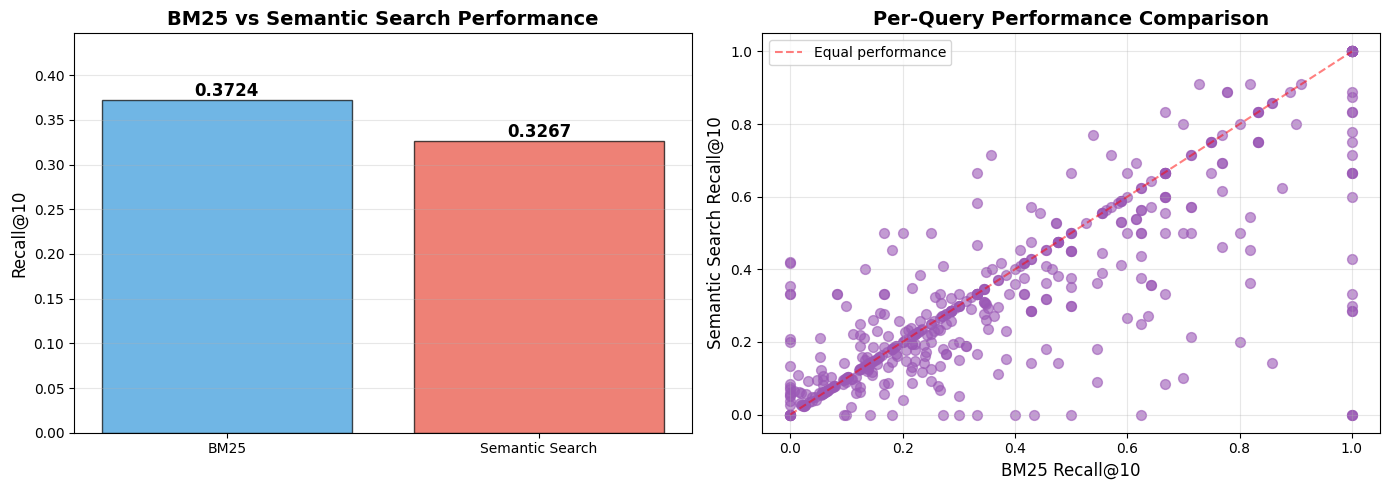


Examples where Semantic Search outperforms BM25:

Query: 'pull out sleeper loveseat'
  BM25 Recall: 0.000 | Semantic Recall: 0.421 | Diff: +0.421

Query: 'day bed indian'
  BM25 Recall: 0.000 | Semantic Recall: 0.417 | Diff: +0.417

Query: 'pool floats'
  BM25 Recall: 0.357 | Semantic Recall: 0.714 | Diff: +0.357

Examples where BM25 outperforms Semantic Search:

Query: 'mom urn'
  BM25 Recall: 1.000 | Semantic Recall: 0.000 | Diff: -1.000

Query: 'white abstract'
  BM25 Recall: 1.000 | Semantic Recall: 0.000 | Diff: -1.000

Query: 'rattan truck'
  BM25 Recall: 1.000 | Semantic Recall: 0.000 | Diff: -1.000


In [26]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart comparing average recalls
ax1 = axes[0]
methods = ["BM25", "Semantic Search"]
recalls = [avg_bm25_recall, avg_semantic_recall]
colors = ["#3498db", "#e74c3c"]

bars = ax1.bar(methods, recalls, color=colors, alpha=0.7, edgecolor="black")
ax1.set_ylabel("Recall@10", fontsize=12)
ax1.set_title("BM25 vs Semantic Search Performance", fontsize=14, fontweight="bold")
ax1.set_ylim(0, max(recalls) * 1.2)
ax1.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, recall in zip(bars, recalls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{recall:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 2: Scatter plot comparing per-query performance
ax2 = axes[1]
ax2.scatter(comparison_df["bm25_recall"], comparison_df["semantic_recall"], 
           alpha=0.6, s=50, color="#9b59b6")
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label="Equal performance")
ax2.set_xlabel("BM25 Recall@10", fontsize=12)
ax2.set_ylabel("Semantic Search Recall@10", fontsize=12)
ax2.set_title("Per-Query Performance Comparison", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xlim(-0.05, 1.05)
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Show some example queries where methods differ
print("\n" + "=" * 80)
print("Examples where Semantic Search outperforms BM25:")
print("=" * 80)
comparison_df["diff"] = comparison_df["semantic_recall"] - comparison_df["bm25_recall"]
top_semantic = comparison_df.nlargest(3, "diff")
for idx, row in top_semantic.iterrows():
    print(f"\nQuery: '{row['query']}'")
    print(f"  BM25 Recall: {row['bm25_recall']:.3f} | Semantic Recall: {row['semantic_recall']:.3f} | Diff: +{row['diff']:.3f}")

print("\n" + "=" * 80)
print("Examples where BM25 outperforms Semantic Search:")
print("=" * 80)
top_bm25 = comparison_df.nsmallest(3, "diff")
for idx, row in top_bm25.iterrows():
    print(f"\nQuery: '{row['query']}'")
    print(f"  BM25 Recall: {row['bm25_recall']:.3f} | Semantic Recall: {row['semantic_recall']:.3f} | Diff: {row['diff']:.3f}")


---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [27]:
# Load the two embedding models
print("Loading embedding models...")
print("=" * 80)

# Model 1:
model_bge = SentenceTransformer("BAAI/bge-base-en-v1.5")
print(f"✓ Loaded BGE model: BAAI/bge-base-en-v1.5")
print(f"  Dimension: {model_bge.get_sentence_embedding_dimension()}")

# Model 2:
model_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
print(f"\n✓ Loaded MPNet model: sentence-transformers/all-mpnet-base-v2")
print(f"  Dimension: {model_mpnet.get_sentence_embedding_dimension()}")

print("\n" + "=" * 80)
print("Both models loaded successfully!")

Loading embedding models...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1677.66it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Loaded BGE model: BAAI/bge-base-en-v1.5
  Dimension: 768


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 911.24it/s, Materializing param=pooler.dense.weight]                         
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



✓ Loaded MPNet model: sentence-transformers/all-mpnet-base-v2
  Dimension: 768

Both models loaded successfully!


In [32]:
# Embed products with both models
print("Embedding products with both models...")
print("=" * 80)

# Get texts to embed (already prepared in products_sample)
texts_to_embed = [str(text) if text else "unknown product" for text in products_sample["combined_text"].tolist()]

# Embed with BGE model
print("\n1. Embedding with BGE model...")
start_time = time.time()
embeddings_bge = model_bge.encode(
    texts_to_embed,
    show_progress_bar=True,
    batch_size=32
)
time_bge = time.time() - start_time
print(f"   ✓ BGE embeddings complete in {time_bge:.2f} seconds")
print(f"   Shape: {embeddings_bge.shape}")

# Embed with MPNet model
print("\n2. Embedding with MPNet model...")
start_time = time.time()
embeddings_mpnet = model_mpnet.encode(
    texts_to_embed,
    show_progress_bar=True,
    batch_size=32
)
time_mpnet = time.time() - start_time
print(f"   ✓ MPNet embeddings complete in {time_mpnet:.2f} seconds")
print(f"   Shape: {embeddings_mpnet.shape}")

print("\n" + "=" * 80)
print("Summary:")
print(f"  BGE:    {embeddings_bge.shape} in {time_bge:.2f}s")
print(f"  MPNet:  {embeddings_mpnet.shape} in {time_mpnet:.2f}s")
print(f"  Speed difference: {abs(time_bge - time_mpnet):.2f}s")


Embedding products with both models...

1. Embedding with BGE model...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches: 100%|██████████| 157/157 [00:08<00:00, 17.99it/s]


   ✓ BGE embeddings complete in 8.76 seconds
   Shape: (5000, 768)

2. Embedding with MPNet model...


Batches: 100%|██████████| 157/157 [00:08<00:00, 17.99it/s]

   ✓ MPNet embeddings complete in 8.76 seconds
   Shape: (5000, 768)

Summary:
  BGE:    (5000, 768) in 8.76s
  MPNet:  (5000, 768) in 8.76s
  Speed difference: 0.00s


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [33]:
# Evaluate both models on all queries
print("Evaluating both embedding models...")
print("=" * 80)

bge_recalls = []
mpnet_recalls = []
model_comparison = []

for idx, query_row in queries_filtered.iterrows():
    query_id = query_row["query_id"]
    query_text = query_row["query"]
    
    # Get relevant products for this query (grade >= 1)
    relevant_labels = labels_filtered[
        (labels_filtered["query_id"] == query_id) & 
        (labels_filtered["grade"] >= 1)
    ]
    relevant_product_ids = relevant_labels["product_id"].tolist()
    
    if len(relevant_product_ids) == 0:
        continue
    
    # Search with BGE model
    bge_results = semantic_search(
        query=query_text,
        model=model_bge,
        doc_embeddings=embeddings_bge,
        products_df=products_sample,
        top_k=10
    )
    bge_retrieved_ids = bge_results["product_id"].tolist()
    bge_recall = recall_at_k(bge_retrieved_ids, relevant_product_ids, k=10)
    bge_recalls.append(bge_recall)
    
    # Search with MPNet model
    mpnet_results = semantic_search(
        query=query_text,
        model=model_mpnet,
        doc_embeddings=embeddings_mpnet,
        products_df=products_sample,
        top_k=10
    )
    mpnet_retrieved_ids = mpnet_results["product_id"].tolist()
    mpnet_recall = recall_at_k(mpnet_retrieved_ids, relevant_product_ids, k=10)
    mpnet_recalls.append(mpnet_recall)
    
    # Store for comparison
    model_comparison.append({
        "query_id": query_id,
        "query": query_text,
        "num_relevant": len(relevant_product_ids),
        "bge_recall": bge_recall,
        "mpnet_recall": mpnet_recall
    })

# Calculate average recalls
avg_bge_recall = np.mean(bge_recalls)
avg_mpnet_recall = np.mean(mpnet_recalls)

print(f"\nEvaluation complete on {len(bge_recalls)} queries")
print("=" * 80)
print(f"\n📊 Results:")
print(f"   BGE Model Recall@10:    {avg_bge_recall:.4f}")
print(f"   MPNet Model Recall@10:  {avg_mpnet_recall:.4f}")
print(f"\n   Difference: {abs(avg_mpnet_recall - avg_bge_recall):.4f}")

if avg_mpnet_recall > avg_bge_recall:
    improvement = ((avg_mpnet_recall - avg_bge_recall) / avg_bge_recall) * 100
    print(f"   MPNet is {improvement:.1f}% better! 🎉")
elif avg_bge_recall > avg_mpnet_recall:
    improvement = ((avg_bge_recall - avg_mpnet_recall) / avg_mpnet_recall) * 100
    print(f"   BGE is {improvement:.1f}% better! 🎉")
else:
    print(f"   Models perform equally!")

# Create comparison DataFrame
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df["diff"] = model_comparison_df["mpnet_recall"] - model_comparison_df["bge_recall"]

# Count wins
print(f"\n🏆 Win/Loss Analysis:")
print(f"   MPNet wins:  {(model_comparison_df['diff'] > 0).sum()} queries")
print(f"   BGE wins:    {(model_comparison_df['diff'] < 0).sum()} queries")
print(f"   Tie:         {(model_comparison_df['diff'] == 0).sum()} queries")

Evaluating both embedding models...

Evaluation complete on 471 queries

📊 Results:
   BGE Model Recall@10:    0.3335
   MPNet Model Recall@10:  0.3162

   Difference: 0.0173
   BGE is 5.5% better! 🎉

🏆 Win/Loss Analysis:
   MPNet wins:  121 queries
   BGE wins:    147 queries
   Tie:         203 queries


In [35]:
# Compare results for specific queries
test_queries = [
    "comfortable sofa", 
    "star wars rug", 
    "modern coffee table",
    "outdoor patio furniture",
    "kids bedroom set"
]

print("Side-by-Side Query Comparison")
print("=" * 80)

for query in test_queries:
    print(f"\n🔍 Query: '{query}'")
    print("-" * 80)
    
    # BGE results
    bge_results = semantic_search(
        query=query,
        model=model_bge,
        doc_embeddings=embeddings_bge,
        products_df=products_sample,
        top_k=5
    )
    
    # MPNet results
    mpnet_results = semantic_search(
        query=query,
        model=model_mpnet,
        doc_embeddings=embeddings_mpnet,
        products_df=products_sample,
        top_k=5
    )
    
    # Display side by side
    print(f"\n{'BGE Model':40} | {'MPNet Model':40}")
    print("-" * 80)
    
    for i in range(5):
        bge_name = bge_results.iloc[i]["product_name"][:35]
        bge_score = bge_results.iloc[i]["score"]
        mpnet_name = mpnet_results.iloc[i]["product_name"][:35]
        mpnet_score = mpnet_results.iloc[i]["score"]
        
        print(f"{i+1}. {bge_name:35} {bge_score:.3f} | {mpnet_name:35} {mpnet_score:.3f}")

print("\n" + "=" * 80)

Side-by-Side Query Comparison

🔍 Query: 'comfortable sofa'
--------------------------------------------------------------------------------

BGE Model                                | MPNet Model                             
--------------------------------------------------------------------------------
1. baeten patio sofa with cushions     0.809 | arshleen patio sofa with cushions   0.748
2. 94 '' square arm sofa with reversib 0.805 | aidann patio sectional with cushion 0.747
3. mccaffery 74 '' round arm sofa      0.801 | lucey patio sectional with cushions 0.736
4. sofa bed with ottoman               0.799 | phokas 93 '' square arm sofa        0.727
5. 86 '' rolled arm sofa with reversib 0.797 | abrish patio sectional with cushion 0.725

🔍 Query: 'star wars rug'
--------------------------------------------------------------------------------

BGE Model                                | MPNet Model                             
---------------------------------------------------------

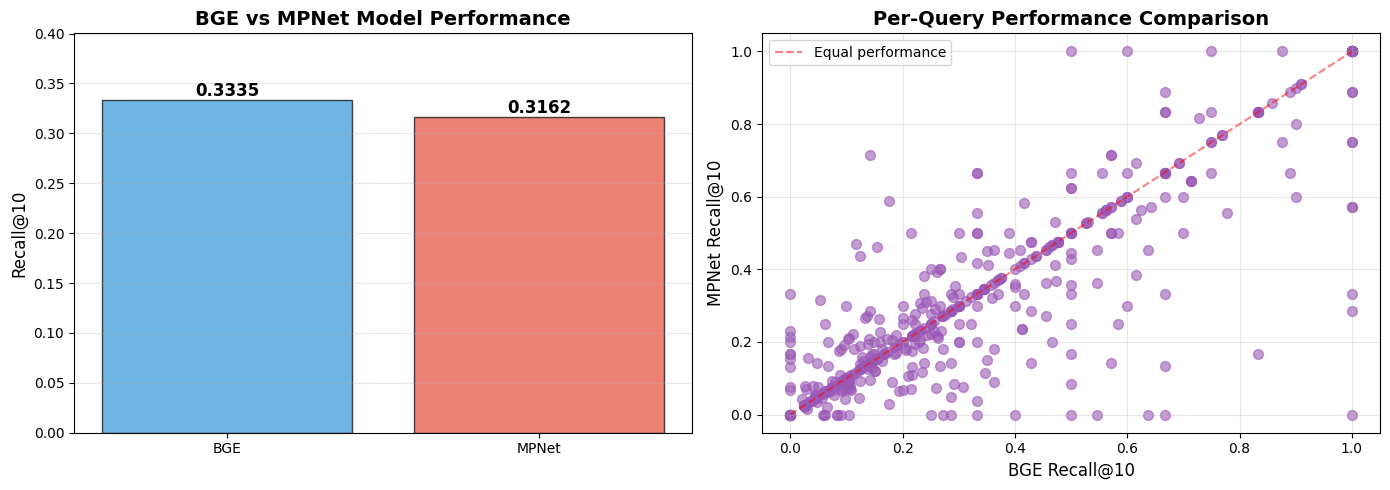


Examples where MPNet outperforms BGE:

Query: 'cake plates with tops'
  BGE Recall: 0.143 | MPNet Recall: 0.714 | Diff: +0.571

Query: 'podium with locking cabinet'
  BGE Recall: 0.500 | MPNet Recall: 1.000 | Diff: +0.500

Query: 'bathroom vanity knobs'
  BGE Recall: 0.176 | MPNet Recall: 0.588 | Diff: +0.412

Examples where BGE outperforms MPNet:

Query: 'mom urn'
  BGE Recall: 1.000 | MPNet Recall: 0.000 | Diff: -1.000

Query: 'malachi sled'
  BGE Recall: 1.000 | MPNet Recall: 0.286 | Diff: -0.714

Query: 'kitchen wooden stand'
  BGE Recall: 0.833 | MPNet Recall: 0.167 | Diff: -0.667

Analysis Summary:
• Both models use 768-dimensional embeddings
• Average performance difference: 0.0173
• The scatter plot shows most points below the diagonal
• Different models may excel on different query types


In [36]:
# Visualize model comparison with a scatter plot
# X-axis: BGE Recall@10, Y-axis: MPNet Recall@10

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart comparing average recalls
ax1 = axes[0]
models = ["BGE", "MPNet"]
recalls = [avg_bge_recall, avg_mpnet_recall]
colors = ["#3498db", "#e74c3c"]

bars = ax1.bar(models, recalls, color=colors, alpha=0.7, edgecolor="black")
ax1.set_ylabel("Recall@10", fontsize=12)
ax1.set_title("BGE vs MPNet Model Performance", fontsize=14, fontweight="bold")
ax1.set_ylim(0, max(recalls) * 1.2)
ax1.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, recall in zip(bars, recalls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{recall:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 2: Scatter plot comparing per-query performance
ax2 = axes[1]
ax2.scatter(model_comparison_df["bge_recall"], model_comparison_df["mpnet_recall"], 
           alpha=0.6, s=50, color="#9b59b6")
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label="Equal performance")
ax2.set_xlabel("BGE Recall@10", fontsize=12)
ax2.set_ylabel("MPNet Recall@10", fontsize=12)
ax2.set_title("Per-Query Performance Comparison", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xlim(-0.05, 1.05)
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Show some example queries where models differ
print("\n" + "=" * 80)
print("Examples where MPNet outperforms BGE:")
print("=" * 80)
top_mpnet = model_comparison_df.nlargest(3, "diff")
for idx, row in top_mpnet.iterrows():
    print(f"\nQuery: '{row['query']}'")
    print(f"  BGE Recall: {row['bge_recall']:.3f} | MPNet Recall: {row['mpnet_recall']:.3f} | Diff: +{row['diff']:.3f}")

print("\n" + "=" * 80)
print("Examples where BGE outperforms MPNet:")
print("=" * 80)
top_bge = model_comparison_df.nsmallest(3, "diff")
for idx, row in top_bge.iterrows():
    print(f"\nQuery: '{row['query']}'")
    print(f"  BGE Recall: {row['bge_recall']:.3f} | MPNet Recall: {row['mpnet_recall']:.3f} | Diff: {row['diff']:.3f}")

print("\n" + "=" * 80)
print("Analysis Summary:")
print("=" * 80)
print(f"• Both models use 768-dimensional embeddings")
print(f"• Average performance difference: {abs(avg_mpnet_recall - avg_bge_recall):.4f}")
print(f"• The scatter plot shows most points {'above' if avg_mpnet_recall > avg_bge_recall else 'below'} the diagonal")
print(f"• Different models may excel on different query types")


---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.